## Data Loader for spectrograms and EEG features

Basic Data Structure --> Dictionary

Dictionary name = all_eegs

{eeg_ig} : [spectrogram, feature engineered data, target labels]

### Upload dataset

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

### Spectrogram functions

In [2]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt, gc
from tqdm import tqdm

train = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
print('Train shape', train.shape )
display( train.head() )



NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

directory_path = 'EEG_Spectrograms_KNN_kis2/'
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    
    
    

import pywt
print("The wavelet functions we can use:")
print(pywt.wavelist())

USE_WAVELET = "db8" #or "db8" or anything below


# DENOISE FUNCTION
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise1(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret

Train shape (106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


The wavelet functions we can use:
['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'haar', 'mexh', 'morl', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5'

In [3]:
import librosa
from sklearn.impute import KNNImputer

def spectrogram_from_eeg(parquet_path, display=False):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    
#     print(np.argwhere(np.isnan(eeg)))
#     print(eeg.iloc[6698])
#     print(eeg.isnull)
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    # KNN imputation
    imputer = KNNImputer(missing_values=np.nan, n_neighbors=2)
    eeg_imputed = imputer.fit_transform(eeg)

    # Update the original DataFrame with the imputed values
    eeg.iloc[:] = eeg_imputed
    
    
    # FILLING NANS EARLY
       
    imputer = KNNImputer(missing_values = np.nan, n_neighbors=3)
    imputer.fit_transform(eeg)
    
#     print(eeg.iloc[6698])
    
    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # DENOISE
            if USE_WAVELET:
                x = denoise1(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            # STANDARDIZE TO -1 TO 1
            mel_spec_db = (mel_spec_db+40)/40 
            img[:,:,k] += mel_spec_db
            

        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
#         # USING KNN TO GET RID OF NAN VALUES
#         imputer = KNNImputer(n_neighbors=2)
#         imputer.fit_transform(img[:,:,k])
        
        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
        
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        print(); print('#'*25); print()
        


    return img

### EEG features functions: denoise, DWT, statistics (MVP, MAVP, std, var, ratio)

In [4]:
# denoising function using wavelet transform
import pywt

def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='db8', level=1):
    #x = x.iloc[:, 1:-7]
    ret = {key:[] for key in x.columns}
    
    for pos in x.columns:
        coeff = pywt.wavedec(x[pos], wavelet, mode="per")
        sigma = (1/0.6745) * maddest(coeff[-level])

        uthresh = sigma * np.sqrt(2*np.log(len(x)))
        coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

        ret[pos]=pywt.waverec(coeff, wavelet, mode='per')
    
    return pd.DataFrame(ret)

# usage

#denoised_eeg_data

In [5]:
# DWT
from pywt import wavedec

def wavelet_decompose_channels(data, level, output=False):
  # take every x number of points using numpy's slicing (start:stop:step)
    data = data[0::2]

    data.columns.name='channel'

    # transpose the data
    data_t = data.transpose()

    # get the wavelet coefficients at each level in a list
    coeffs_list = wavedec(data_t.values, wavelet='db4', level=level)
    #print(len(coeffs_list))

    # make a list of the component names (later column rows)
    nums = list(range(1,level+1))
    names=[]
    for num in nums:
        names.append('D' + str(num))
    names.append('A' + str(nums[-1]))

  # reverse the names so it counts down
    names = names[::-1]  
    #print(names)

    i = 0
    wavelets = pd.DataFrame()
    for i in range(1, len(coeffs_list)):
    #for i, array in enumerate(coeffs_list):
        #print(i)
        array = coeffs_list[i]
        # turn into a dataframe and transpose
        level_df = pd.DataFrame(array)
        level_df.index = data.columns
        level_df['level'] = names[i]
        level_df= level_df.set_index('level', append=True)
        level_df=level_df.T
        # add the next levels df to another column
        wavelets = pd.concat([wavelets,level_df], axis=1, sort=True)

    # sort values along the channels
    wavelets = wavelets.sort_values(['channel', 'level'], axis=1)

  # remove the AN levels
  #regex = re.compile('D')
  #bad_items = [x for x in list(wavelets.columns.levels[1]) if not regex.match(x)]
  #decom_wavelets = wavelets.drop(bad_items, axis=1, level = 'level')

  #decom_wavelets.index.name='sample'

  #if output:
  #  display(decom_wavelets.head())

    wavelets_cleaned = wavelets.dropna()

    return wavelets_cleaned

# usage
#dwt_wavelets = wavelet_decompose_channels(denoised_eeg_data, level=5, output=True)
#dwt_wavelets

In [7]:
from scipy.stats import entropy

def MAV(data):
    # Initialize an empty DataFrame to store the means for each channel
    means = pd.DataFrame(index=data.index)

    # Iterate over each channel and calculate the mean across 'D1' to 'D5'
    for channel in data.columns.get_level_values(0).unique():
    # Calculate the mean for the current channel
        means[channel] = data[channel].abs().mean(axis=1)
    
    means.columns = [f"{col}_DT_MAV" for col in means.columns]
    
    return means


def MAVP(data):
    # Initialize an empty DataFrame to store the means for each channel
    means_abs = pd.DataFrame(index=data.index)

    # Iterate over each channel and calculate the mean across 'D1' to 'D5'
    for channel in data.columns.get_level_values(0).unique():
    # Calculate the mean for the current channel
        means_abs[channel] = (data[channel]**2).mean(axis = 1)
    
    means_abs.columns = [f"{col}_DT_MAVP" for col in means_abs.columns]
    
    return means_abs



def std_val(data):
    # Initialize an empty DataFrame to store the means for each channel
    std_vals = pd.DataFrame(index=data.index)

    # Iterate over each channel and calculate the mean across 'D1' to 'D5'
    for channel in data.columns.get_level_values(0).unique():
    # Calculate the mean for the current channel
        std_vals[channel] = data[channel].std(axis = 1)
    
    std_vals.columns = [f"{col}_DT_STD" for col in std_vals.columns]
    
    return std_vals


def var_val(data):
    # Initialize an empty DataFrame to store the means for each channel
    var = pd.DataFrame(index=data.index)

    # Iterate over each channel and calculate the mean across 'D1' to 'D5'
    for channel in data.columns.get_level_values(0).unique():
    # Calculate the mean for the current channel
        var[channel] = data[channel].var(axis = 1)
    
    var.columns = [f"{col}_DT_VAR" for col in var.columns]
    
    return var


def ratio_channels(epoch_data):
    # Initialize an empty DataFrame to store the ratio values for each pair of channels
    ratio_data = pd.DataFrame(index=epoch_data.index)
    
    # Iterate over each pair of adjacent channels
    for i in range(len(epoch_data.columns) - 1):
        channel1 = epoch_data.columns[i]
        channel2 = epoch_data.columns[i + 1]
        
        # Calculate the ratio between the values of the two channels
        ratio_data[f"{channel1}-{channel2}_Ratio"] = epoch_data[channel1] / epoch_data[channel2]
    
    return ratio_data



def shannon_entropy(data):
    # Initialize an empty DataFrame to store the entropy values for each channel
    entropy_df = pd.DataFrame(index=data.index)

    # Iterate over each channel and calculate the entropy across 'D1' to 'D5'
    for channel in data.columns.get_level_values(0).unique():
        # Calculate the entropy for the current channel
        entropy_values = data[channel].apply(lambda x: entropy(x.abs(), base=2), axis=1)
        entropy_df[channel + '_entropy'] = entropy_values

    return entropy_df

In [8]:
def eeg_feature(data):
    
    wavelet_mean = MAV(data)
    wavelet_meanabs = MAVP(data)
    wavelet_std = std_val(data)
    wavelet_var = var_val(data)
    wavelet_ratio = ratio_channels(data)
    wavelet_entropy = shannon_entropy(data)
    
    wavelet_statistics = pd.concat([data, wavelet_mean, wavelet_meanabs, wavelet_std, wavelet_var, wavelet_ratio, wavelet_entropy], axis=1)
    
    return wavelet_statistics


# usage
#eeg_features = eeg_feature(dwt_wavelets)
#eeg_features

In [ ]:
# using sample data for trial
import random

ids = train.eeg_id.unique()

n = 10
ids1 = random.sample(list(ids), n)
ids1

In [9]:
def feature_eng_eeg(parquet_path, display=False):
    
    # extract 10 seconds
    eegid_data = pd.read_parquet(parquet_path)
    all_segments = []
    segment_length = 10  # 10-second EEG segments
            
    # Filter training data for the current EEG ID
    train_eegid = train[train['eeg_id'] == eeg_id]
   
    offset_values_list = train_eegid['eeg_label_offset_seconds'].tolist()
    print("Number of offset subsamples for EEG ID", eeg_id, ":", len(offset_values_list))
    
    # Extract 10-second EEG segments along with target labels
    for offset in offset_values_list:
        start_index = int(offset) * 200
        end_index = start_index + (segment_length * 200)
        # Extract 10-second segment centered around the offset
        middle_index = (start_index + end_index) // 2
        segment_start = middle_index - (segment_length // 2 * 200)
        segment_end = middle_index + (segment_length // 2 * 200)
        # Extract EEG segment
        eeg_segment = eegid_data.iloc[segment_start:segment_end].reset_index(drop=True)
        all_segments.append(eeg_segment)
    # Concatenate all segments into a single DataFrame
    full_eeg_segments = pd.concat(all_segments, ignore_index=True)
        
    # Denoise
    denoised_eeg_data = denoise(full_eeg_segments, wavelet='db8') 
    
    # DWT
    dwt_wavelets = wavelet_decompose_channels(denoised_eeg_data, level=5, output=True)
    
    # getting all features
    eegid_data_features = eeg_feature(dwt_wavelets)
    
    return eegid_data_features


In [ ]:
#PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/'
#eeg_id = 1639794967
#all_features_data = feature_eng_eeg(f'{PATH}{eeg_id}.parquet')
#all_features_data

In [ ]:
#all_features_data.isnull().values.any()

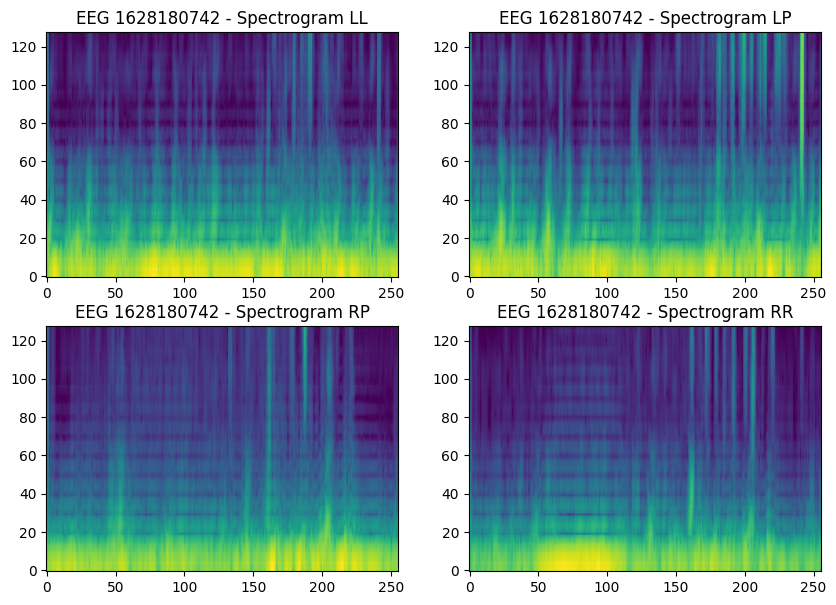

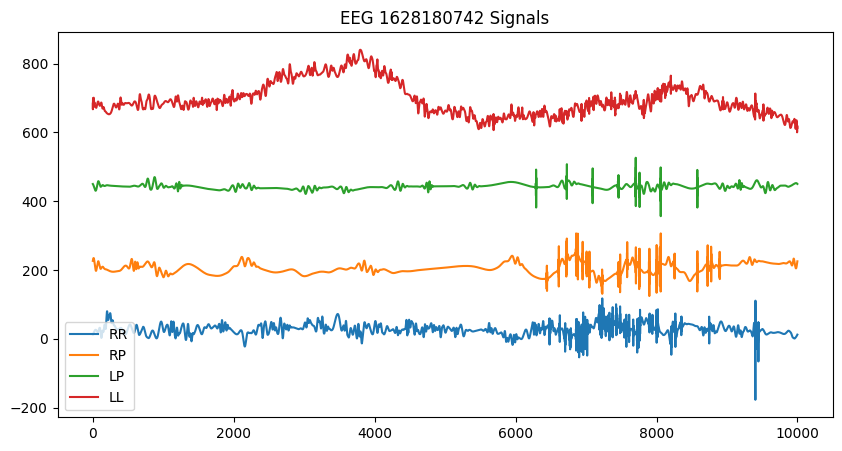


#########################

Number of offset subsamples for EEG ID 1628180742 : 9


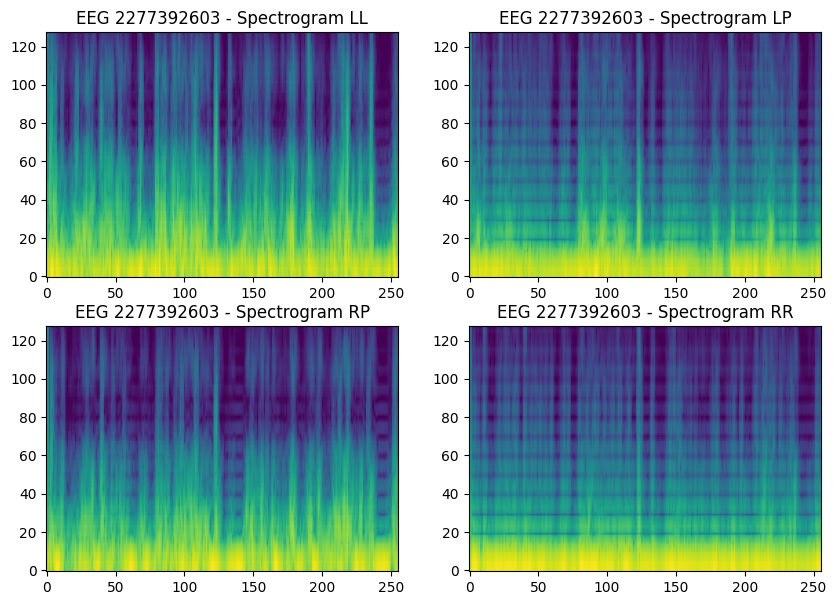

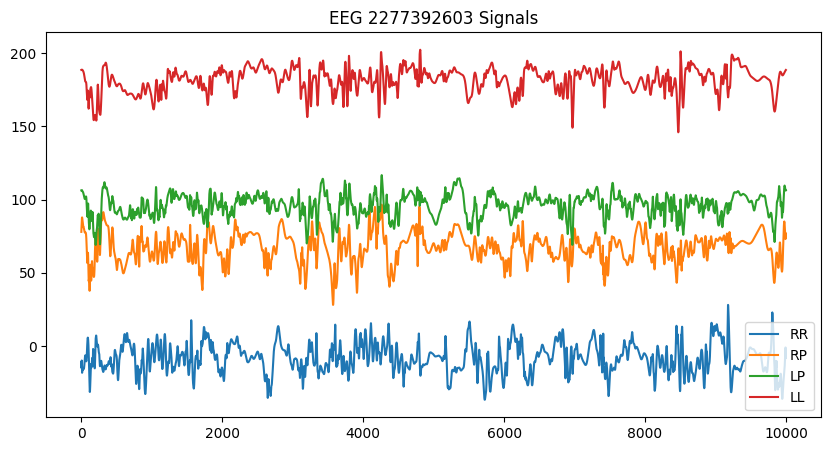


#########################

Number of offset subsamples for EEG ID 2277392603 : 2


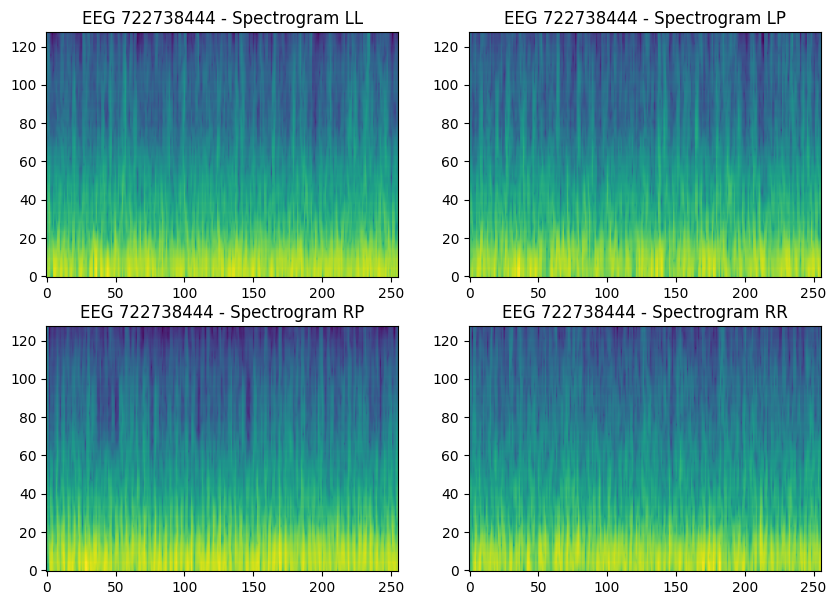

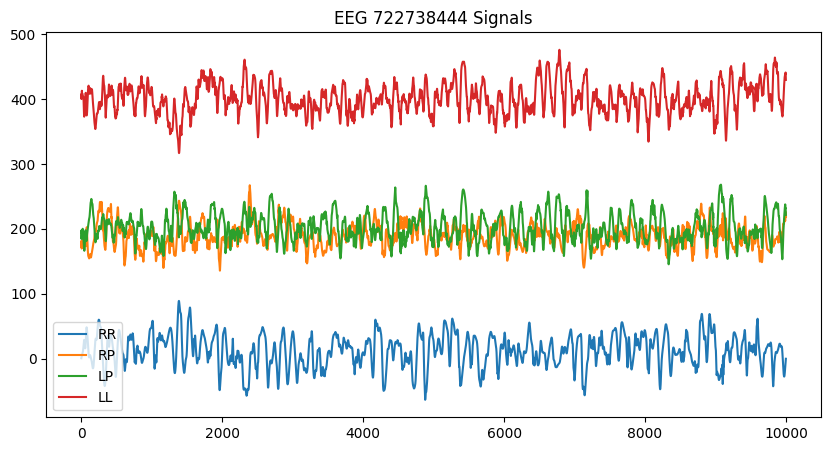


#########################

Number of offset subsamples for EEG ID 722738444 : 11


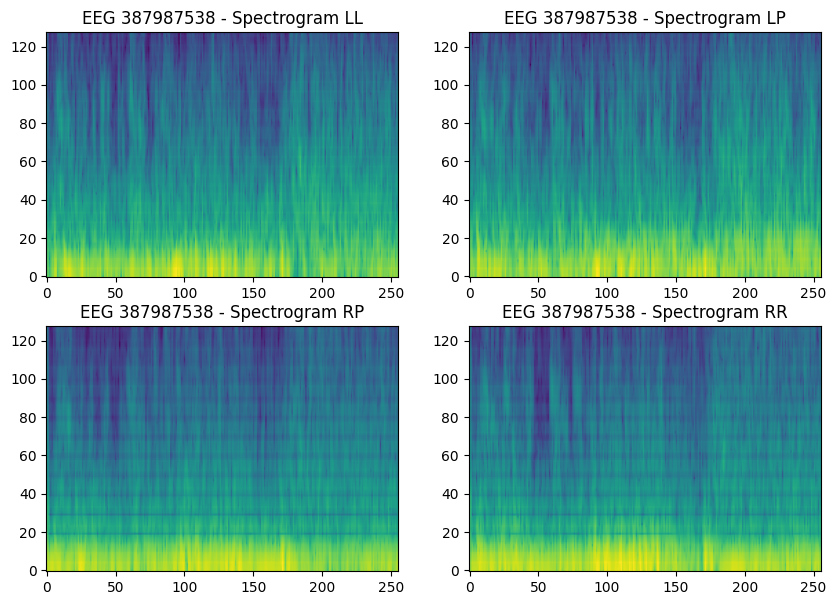

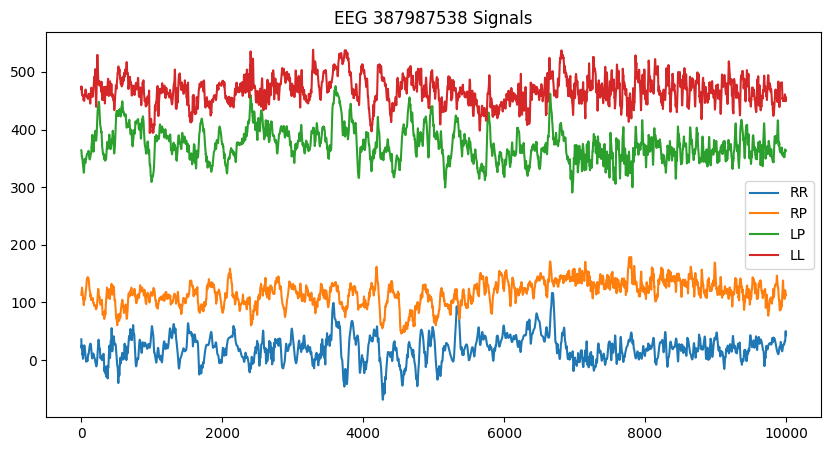


#########################

Number of offset subsamples for EEG ID 387987538 : 6
Number of offset subsamples for EEG ID 2175806584 : 2
Creating and writing 17089 spectrograms to disk... Number of offset subsamples for EEG ID 1626798710 : 2
Number of offset subsamples for EEG ID 2529955608 : 3
Number of offset subsamples for EEG ID 1202099836 : 1
Number of offset subsamples for EEG ID 3037445252 : 2
Number of offset subsamples for EEG ID 2289322082 : 3
Number of offset subsamples for EEG ID 2295963202 : 8
Number of offset subsamples for EEG ID 2882017352 : 5
Number of offset subsamples for EEG ID 2578018731 : 4
Number of offset subsamples for EEG ID 8071080 : 4
Number of offset subsamples for EEG ID 989810287 : 3
Number of offset subsamples for EEG ID 3083733314 : 1
Number of offset subsamples for EEG ID 175641702 : 1
Number of offset subsamples for EEG ID 138236967 : 1
Number of offset subsamples for EEG ID 1448756052 : 1
Number of offset subsamples for EEG ID 374504640 : 14
Number of 

In [ ]:
%%time
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/'
DISPLAY = 4
EEG_IDS = train.eeg_id.unique()
#EEG_IDS = ids1 # use this for sample data
all_eegs = {}
# for i,eeg_id in tqdm(enumerate(EEG_IDS)): # use this when in kaggle notebook
for i,eeg_id in enumerate(EEG_IDS):         # use this when saving output
    if (i%100==0)&(i!=0): print(i,', ',end='')
        
    # CREATE SPECTROGRAM FROM EEG PARQUET
    img = spectrogram_from_eeg(f'{PATH}{eeg_id}.parquet', i<DISPLAY)
    
    # CREATE FEATURES FROM EEG PARQUET
    all_features_data = feature_eng_eeg(f'{PATH}{eeg_id}.parquet')
    # Remove rows with NaN values in feature data
    clean_features_data = all_features_data.dropna()
    
    if clean_features_data.empty:
        continue 
    
    # GET TARGET LABELS FOR SPECIFIC EEF_ID
    train_eegid = train[train['eeg_id'] == eeg_id]
    target_labels = train.iloc[0][['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]

    # SAVE TO DISK
    if i==DISPLAY:
        print(f'Creating and writing {len(EEG_IDS)} spectrograms to disk... ',end='')
    np.save(f'{directory_path}{eeg_id}',img)
    np.save(f'{directory_path}{eeg_id}_features.npy', clean_features_data)
    all_eegs[eeg_id] = (img, clean_features_data, target_labels)

   
# SAVE EEG SPECTROGRAM DICTIONARY
np.save('/kaggle/working/full_dataset',all_eegs)